## Imports

In [216]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import keras
from IPython import display
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend
from keras import Sequential
from tqdm import tqdm

## Load dataset

In [217]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
print(X_train.shape)
print(Y_train.shape)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299 , 0.587, 0.114])
convert = lambda pic : rgb2gray(pic)

X_train = convert(X_train)
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(267, 32, 32, 3)
(267, 1)
(267, 32, 32, 1)


## Analizo imágenes

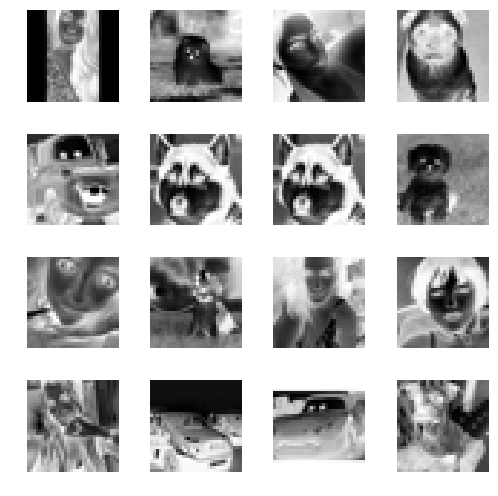

In [218]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [219]:
label_values = {
  0: "car",
  1: "dog",
  2: "face"  
}

Image index: 210
Label index: 2
Label: face


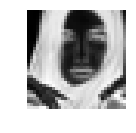

In [220]:
index = np.random.choice(X_train.shape[0],1)
print("Image index:", index[0])
print("Label index:", Y_train[index][0][0])
label_index = Y_train[index][0][0]
print("Label:", label_values[label_index])
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Normalizo las imágenes

In [221]:
print(np.min(X_train), np.max(X_train))

0.0 255.0


In [222]:
x_pixels = X_train.astype('float32')
print(np.min(x_pixels), np.max(x_pixels))
x_pixels = x_pixels - 127.5
print(np.min(x_pixels), np.max(x_pixels))
x_pixels /= 127.5
print(np.min(x_pixels), np.max(x_pixels))
X_train = x_pixels

0.0 255.0
-127.5 127.5
-1.0 1.0


In [223]:
print(np.min(X_train), np.max(X_train))

-1.0 1.0


In [224]:
print(np.min(Y_train), np.max(Y_train))

0 2


In [225]:
Y_train = Y_train.reshape(-1, 1)

In [226]:
print(np.min(Y_train), np.max(Y_train))

0 2


In [227]:
print('Shape de X_train:', X_train.shape)
print('Cantidad de muestras:',X_train.shape[0])

Shape de X_train: (267, 32, 32, 1)
Cantidad de muestras: 267


In [228]:
print('Shape de Y_train:', Y_train.shape)
print('Cantidad de muestras:',Y_train.shape[0])

Shape de Y_train: (267, 1)
Cantidad de muestras: 267


## Train settings

In [229]:
img_size = 32
noise_size = 2048
num_classes = 3
latent_dim = 100
img_rows = img_size
img_cols = img_size
channels = 1
img_shape = (img_rows, img_cols, channels)

## Generator

In [241]:
generator = Sequential()

generator.add(Dense(256, input_dim=latent_dim))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(np.prod(img_shape), activation='tanh'))
generator.add(Reshape(img_shape))

generator.summary()

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

model_input = multiply([noise, label_embedding])
img = generator(model_input)
generator = Model([noise, label], img)

plot_model(generator, to_file='generator_plot_custom.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_42 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              525312    
__________

## Discriminator

In [242]:
discriminator = Sequential()

discriminator.add(Dense(512, input_dim=np.prod(img_shape)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

img = Input(shape=img_shape)
label = Input(shape=(1,), dtype='int32')

label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
flat_img = Flatten()(img)

model_input = multiply([flat_img, label_embedding])

validity = discriminator(model_input)
discriminator = Model([img, label], validity)

plot_model(generator, to_file='discriminator_plot_custom.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 512)               0         
__________

## Juntar modelos de Generador y Discriminador para generar GAN

In [243]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

# The generator takes noise and the target label as input
# and generates the corresponding digit of that label
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
# and the label of that image
valid = discriminator([img, label])

# The combined model  (stacked generator and discriminator)
# Trains generator to fool discriminator
GAN = Model([noise, label], valid)
GAN.compile(loss=['binary_crossentropy'], optimizer=optimizer)
GAN.summary()

plot_model(GAN, to_file='gan_plot_custom.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_16 (Model)                (None, 32, 32, 1)    1739820     input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
model_17 (Model)                (None, 1)            1053697     model_16[1][0]                   
          

## Pre train

In [244]:
# Número de iteraciones
ntrain = 2
# Tomo datos al azar para entrenar
trainidx = np.random.choice(X_train.shape[0], ntrain)
labels_train = Y_train[trainidx]
print("labels_train", labels_train.shape)
images_train = X_train[trainidx,:,:,:]
print("images_train", images_train.shape)

# Pre-entrenar al discriminador
#Genero ruido
noise = np.random.randn(ntrain, latent_dim)

#Tomo labels random
labels_sample = np.random.randint(0, 3, ntrain).reshape(-1, 1)
print("labels_sample", labels_sample.shape)

#Genero imágenes con el generador a partir del ruido
generated_images = generator.predict([noise, labels_sample])
print("images_sample", generated_images.shape)

#Junto las imágenes generadas con las originales del dataset
labels_concat = np.concatenate((labels_train, labels_sample))
images_concat = np.concatenate((images_train, generated_images))
print("labels_concat", labels_concat.shape)
print("images_concat", images_concat.shape)

#Trato de engañar al discriminador diciendo que todas las imágenes son reales
valid = np.zeros((labels_concat.shape[0], 1)) - (np.random.random()*0.1)
print("valid", valid.shape)

#Permito cambiar los pesos del discriminador
discriminator.trainable = True

#Pre-entreno
discriminator.fit([images_concat, labels_concat], valid, epochs=1, batch_size=32)

labels_train (2, 1)
images_train (2, 32, 32, 1)
labels_sample (2, 1)
images_sample (2, 32, 32, 1)
labels_concat (4, 1)
images_concat (4, 32, 32, 1)
valid (4, 1)
Epoch 1/1
4/4 [==============================] - 3s 640ms/step - loss: 0.6949 - acc: 0.0000e+00


In [245]:
#Predigo
y_hat = discriminator.predict([images_concat, labels_concat])

#Analizo los resultados del discriminador pre-entrenado
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(valid,axis=1)
diff = y_idx-y_hat_idx
n_tot = valid.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Precisión: %0.02f imágenes (%d de %d) correctas"%(acc, n_rig, n_tot))

Precisión: 100.00 imágenes (4 de 4) correctas


## Train process

In [246]:
def train(epochs, batch_size=128, sample_interval=50):
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in tqdm(range(epochs)):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], Y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a half batch of new images
        gen_imgs = generator.predict([noise, labels])

        #Permito entrenar al discriminador
        discriminator.trainable = True
        
        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------
        
        # Congelo los pesos del discriminador para que no se modifiquen en esta parte del entrenamiento del GAN
        discriminator.trainable = False
        
        # Condition on labels
        sampled_labels = np.random.randint(0, 3, batch_size).reshape(-1, 1)

        # Train the generator
        g_loss = GAN.train_on_batch([noise, sampled_labels], valid)

        losses["g"].append(g_loss)
        losses["d"].append(d_loss)
        
        # Plot the progress
        # print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_loss, g_loss))
        
        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            plot_loss(losses)
            sample_images(epoch)
            predict()
            generator.save('saved_models/cgan_generator_model_3_own.h5')
            discriminator.save('saved_models/cgan_discriminator_model_3_own.h5')
            GAN.save('saved_models/cgan_model_3_own.h5')

## Generate sample images

In [247]:
def sample_images(epoch):
    r = 1
    c = 3
    noise = np.random.randn(3, latent_dim)
    sample_label = np.arange(0, 3).reshape(-1, 1)
    gen_img = generator.predict([noise, sample_label])
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for j in range(c):
        img = image.array_to_img(gen_img[cnt])
        axs[j].imshow(img)
        axs[j].set_title(label_values[sample_label[cnt][0]])
        axs[j].axis('off')
        cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

## Plot loss from training

In [248]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='Pérdida del discriminador')
        plt.plot(losses["g"], label='Pérdida del generador')
        plt.legend()
        plt.show()

In [249]:
losses = {"d":[], "g":[]}

## Train!

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

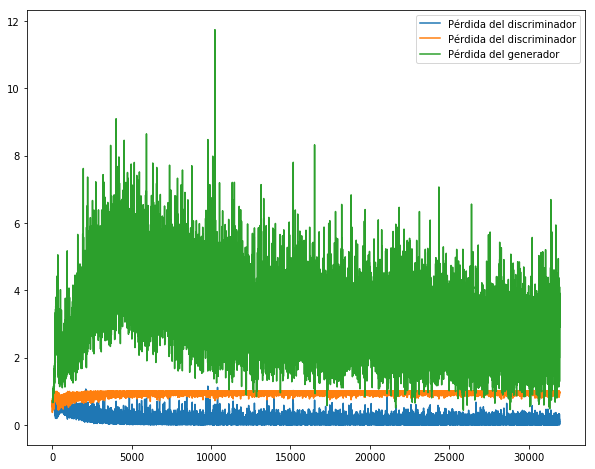

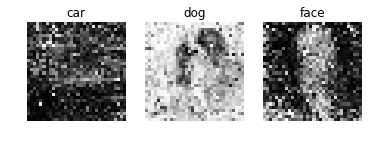

100%|██████████| 5000/5000 [04:18<00:00, 19.32it/s]


In [253]:
train(epochs=5000)

In [102]:
generator.save('saved_models/cgan_generator_model_3_own.h5')
discriminator.save('saved_models/cgan_discriminator_model_3_own.h5')
GAN.save('saved_models/cgan_model_3_own.h5')

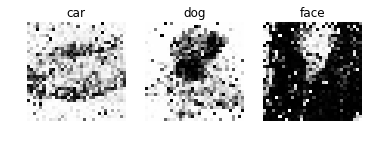

In [255]:
def predict():
    r = 1
    c = 3
    noise = np.random.randn(3, latent_dim)
    sample_label = np.arange(0, 3).reshape(-1, 1)
    gen_img = generator.predict([noise, sample_label])
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for j in range(c):
        img = image.array_to_img(gen_img[cnt])
        axs[j].imshow(img)
        axs[j].set_title(label_values[sample_label[cnt][0]])
        axs[j].axis('off')
        cnt += 1
    plt.show()        
    plt.close()
    
predict()    

car


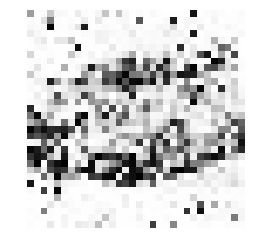

In [257]:
def predictOne(label=0):
    noise = np.random.randn(3, latent_dim)
    sample_label = np.arange(0, 3).reshape(-1, 1)
    gen_img = generator.predict([noise, sample_label])
    img = image.array_to_img(gen_img[label])
    plt.imshow(img)
    print(label_values[sample_label[label][0]])
    plt.axis('off')
    plt.show()        
    plt.close()
    
predictOne()    

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(3, 100)
(3, 1)


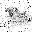

In [258]:
from keras.models import load_model
label=1
cgan_loaded = load_model('saved_models/cgan_generator_model_3_own.h5')
noise_size = 100
noise = np.random.randn(3, noise_size)
sample_label = np.arange(0, 3).reshape(-1, 1)
print(noise.shape)
print(sample_label.shape)
gen_img = cgan_loaded.predict([noise, sample_label])
img = image.array_to_img(gen_img[label])
img